In [2]:
import openslide
from matplotlib.colors import ListedColormap
from skimage import color
import skimage.morphology  as skmp

In [8]:
import glob
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import time
import skimage.io as io

In [2]:
!pip install openslide-python

     |████████████████████████████████| 338 kB 10.5 MB/s eta 0:00:01
  Created wheel for openslide-python: filename=openslide_python-1.2.0-cp39-cp39-linux_x86_64.whl size=17543 sha256=cd1da722398af3df25030db082a178f4f78f321859bdbda5ecd1ff43d3b90a84
  Stored in directory: /home/eredekop/.cache/pip/wheels/ad/84/69/1b8062b5e72d19f9fc3586e1946ee99ea65403e3133ecad1f5
Successfully built openslide-python


## class distribution

### train

In [4]:
df_train = pd.read_csv('/data/neuro/stroke/kaggle_strip_ai/train.csv')
df_train

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE
...,...,...,...,...,...
749,fe9645_0,3,fe9645,0,CE
750,fe9bec_0,4,fe9bec,0,LAA
751,ff14e0_0,6,ff14e0,0,CE
752,ffec5c_0,7,ffec5c,0,LAA


In [5]:
print('CE class: ', df_train[df_train['label'] == 'CE'].shape[0])
print('LLA class: ', df_train[df_train['label'] == 'LAA'].shape[0])

CE class:  547
LLA class:  207


### test

In [6]:
df_test = pd.read_csv('/data/neuro/stroke/kaggle_strip_ai/test.csv')
df_test

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


## Data extraction and preprocessing

In [7]:
all_files = glob.glob('/data/neuro/stroke/kaggle_strip_ai/train/*.tif')
all_files

['/data/neuro/stroke/kaggle_strip_ai/train/006388_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/008e5c_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/00c058_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/01adc5_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/026c97_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/028989_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/029c68_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/032f10_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/0372b0_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/037300_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/03d1ec_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/03e6b7_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/0415c3_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/04439c_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/045eb0_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/0468a8_0.tif',
 '/data/neuro/stroke/kaggle_strip_ai/train/0468a8_1.tif',
 '/data/neuro/

### openslide analysis

In [10]:
slide_path = all_files[0]
slide = openslide.OpenSlide(slide_path)

In [34]:
image_id = slide_path.split('/')[::-1][0].split('.')[0]
df_train[df_train['image_id']==str(image_id)]['label']

image class:  0    CE
Name: label, dtype: object


In [35]:
print('stored dimenions: ', slide.level_dimensions)
print('stored downsampled levels: ', slide.level_downsamples)
print('slide_properties: ', slide.properties)

stored dimensions:  ((34007, 60797),)
stored downsampled levels:  (1.0,)
slide_properties:  <_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '60797', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '34007', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>


### extract thumbnail - lower resolution

In [11]:
### try exctracting thumbnail using skimage
t1 = time.time()
resize_factor = 8
img = io.imread(slide_path)
thumbnail = cv2.resize(img, dsize=None, fx=1/resize_factor, fy=1/resize_factor)
print('thumbnail shape: ', thumbnail.shape, 'time: ', time.time() - t1)

thumbnail shape:  (7600, 4251, 3) time:  39.67464208602905


In [13]:
### try exctracting thumbnail using skimage and bicubic interpolation
t1 = time.time()
resize_factor = 8
img = io.imread(slide_path)
thumbnail = cv2.resize(img, dsize=None, fx=1/resize_factor, fy=1/resize_factor, interpolation=cv2.INTER_CUBIC)
print('thumbnail shape: ', thumbnail.shape, 'time: ', time.time() - t1)

thumbnail shape:  (7600, 4251, 3) time:  44.46777153015137


In [12]:
### try exctracting thumbnail using openslide
t1 = time.time()
down_rate = 8
size = np.array(slide.level_dimensions)[0]//down_rate
print(size)
thumbnail = np.array(slide.get_thumbnail([size[0], size[1]]).convert('RGB'))
print('thumbnail shape: ', thumbnail.shape, 'time: ', time.time() - t1)

[4250 7599]
thumbnail shape:  (7598, 4250, 3) time:  137.5174720287323


In [17]:
### try exctracting thumbnail using tifffile
down_rate = 16
tif = tifffile.TiffFile(slide_path)
image  = tif.series[0].asarray().astype(np.uint8)
thumbnail = cv2.resize(image, (tif.series[0].shape[1]//down_rate,tif.series[0].shape[0]//down_rate), interpolation=cv2.INTER_CUBIC)
print('thumbnail shape: ', thumbnail.shape, 'time: ', time.time() - t1)

thumbnail shape:  (3862, 953, 3) time:  128.07207345962524


(-0.5, 1905.5, 7724.5, -0.5)

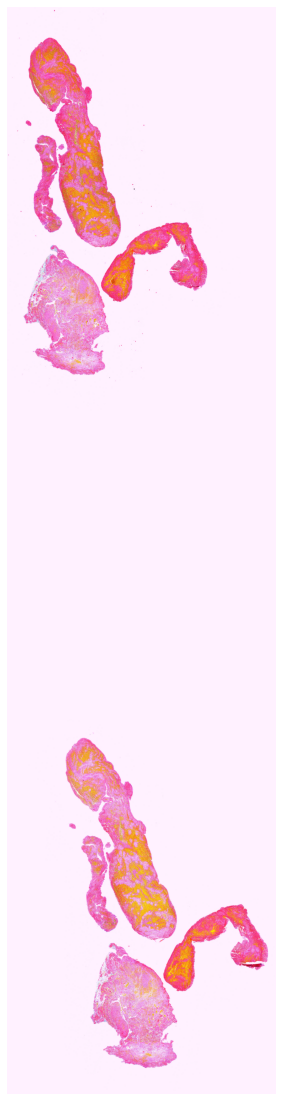

In [85]:
plt.figure(figsize=(20,20))
plt.imshow(thumbnail, cmap='gray')
plt.axis('off')

In [71]:
from PIL import Image

from histolab.filters.image_filters import (
    ApplyMaskImage,
    Compose,
    OtsuThreshold,
    RgbToGrayscale,GreenPenFilter,BluePenFilter
)
from histolab.filters.morphological_filters import BinaryDilation,BinaryErosion,BinaryClosing,BinaryOpening,RemoveSmallObjects,RemoveSmallHoles

def composed_filters(image_rgb):
    filters = Compose(
        [
            RgbToGrayscale(),
            OtsuThreshold(),
#             BinaryDilation(),
#             BinaryErosion(),
            BinaryClosing(),
            RemoveSmallHoles(),
#             BinaryClosing(),
#             BinaryDilation(),
            RemoveSmallObjects(),
            ApplyMaskImage(image_rgb),
            BluePenFilter(),
            GreenPenFilter(),

        ]
    )
    return filters(image_rgb)


image_rgb = Image.fromarray(thumbnail)
resulting_image = composed_filters(image_rgb)


In [72]:
np.array(resulting_image).shape

(5419, 2054, 3)

(-0.5, 2053.5, 5418.5, -0.5)

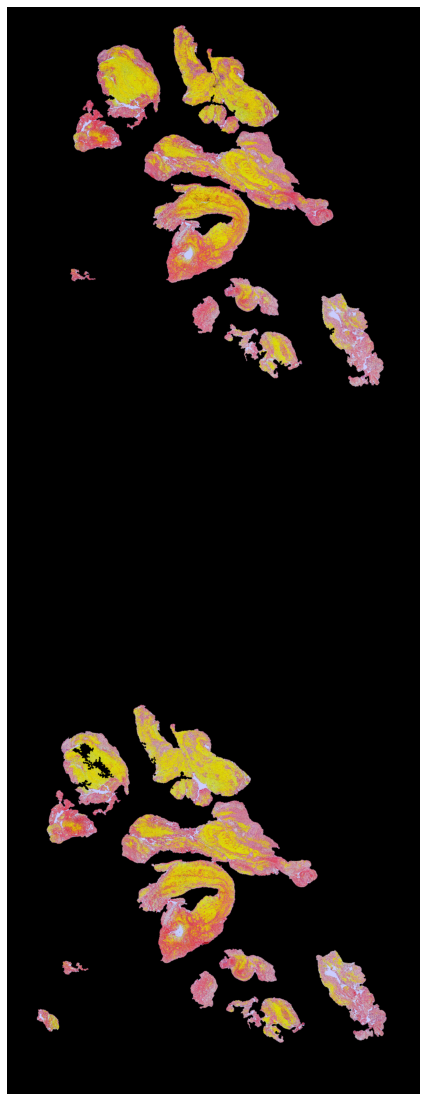

In [73]:
plt.figure(figsize=(20,20))
plt.imshow(resulting_image)
plt.axis('off')

In [19]:
from histolab.tiler import GridTiler

In [25]:
from histolab.slide import Slide
slide = Slide(slide_path, processed_path='/data/eredekop/stroke_kaggle/processed')

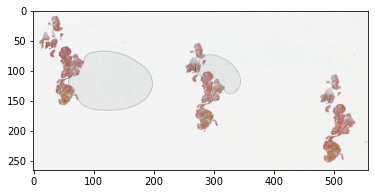

In [34]:
plt.imshow(np.array(slide.thumbnail))

In [35]:
grid_tiles_extractor = GridTiler(
   tile_size=(512, 512),
   level=0,
   check_tissue=True,
   pixel_overlap=0, # default
   prefix="grid/", # save tiles in the "grid" subdirectory of slide's processed_path
   suffix=".png" # default
)

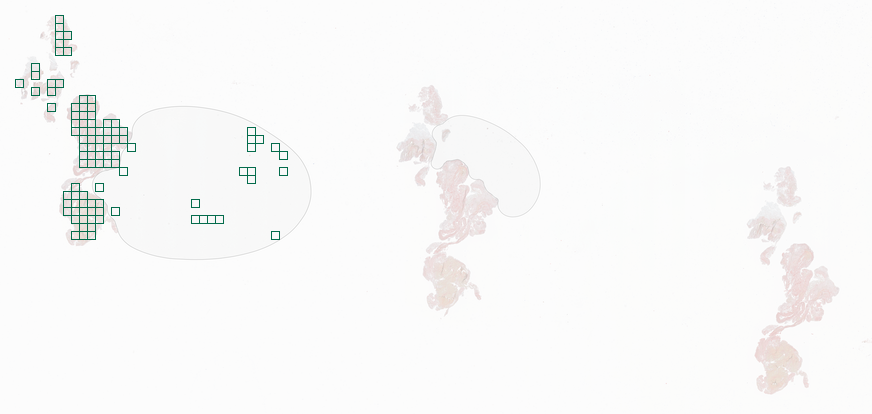

In [36]:
grid_tiles_extractor.locate_tiles(
    slide=slide,
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
)

In [150]:
!pip install histolab

     |████████████████████████████████| 32.5 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 81.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.1
    Uninstalling scikit-image-0.18.1:
      Successfully uninstalled scikit-image-0.18.1


In [152]:
!pip install scikit-image==0.18.1

     |████████████████████████████████| 28.9 MB 11.4 MB/s eta 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.2
    Uninstalling scikit-image-0.19.2:
      Successfully uninstalled scikit-image-0.19.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
histolab 0.5.1 requires scikit-image<0.19.3,>=0.19.0, but you have scikit-image 0.18.1 which is incompatible.
